## Load libraries

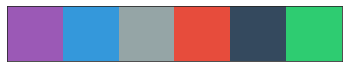

In [149]:
# Toolbox
from pathlib import Path
from PIL import Image
from skimage.io import imread
from skimage.transform import resize
import imgaug as aug
import imgaug.augmenters as imaug
import os
import numpy as np
import pandas as pd 
import seaborn as sns
import random
import sys
import matplotlib.pyplot as plt
%matplotlib inline

# Deep learning libraries
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, ReLU, Activation
from keras.optimizers import Adam, SGD, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import keras
import tensorflow as tf
import tensorflow.keras
import cv2

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score, f1_score
from sklearn.metrics import precision_recall_curve, auc
from mlxtend.plotting import plot_confusion_matrix

# Misc
import os
import warnings
warnings.filterwarnings(action='ignore')

# Preset data display
pd.options.display.max_seq_items = 1000
pd.options.display.max_rows =1000
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 500)

# Set notebook colors and palette
flatui = ['#9b59b6', '#3498db', '#95a5a6', '#e74c3c', '#34495e', '#2ecc71']
sns.set_palette(flatui)
sns.palplot(sns.color_palette(flatui))
sns.set_style('white')
sns.set_color_codes(palette='deep')
# Favorite code to use: #34995e

# Setting seeds for reproducibility
seed = 100
np.random.seed(seed)
tf.set_random_seed(seed)

In [78]:
print('These are the current versions working for me as of 2019-08-07')
print(f"OpenCV Version: {cv2.__version__}")
print(f"TensorFlow Version: {tf.__version__}")
print(f"TensorFlow Keras Version: {tensorflow.keras.__version__}")
print(f"Keras Version: {keras.__version__}")
print()
print("TensorFlow-GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")
print(f"TensorFlow CUDA: {tf.test.is_built_with_cuda()}")
print(f"Tensorflow GPU Device Currently Activated: {tf.test.gpu_device_name()}")
print(f"Keras GPU: {keras.backend.tensorflow_backend._get_available_gpus()}")
print()
print(f"TF Session: {tf.Session()}")
print()
print(f"Python {sys.version}")

These are the current versions working for me as of 2019-08-07
OpenCV Version: 4.0.1
TensorFlow Version: 1.13.1
TensorFlow Keras Version: 2.2.4-tf
Keras Version: 2.2.4

TensorFlow-GPU is available
TensorFlow CUDA: True
Tensorflow GPU Device Currently Activated: /device:GPU:0
Keras GPU: ['/job:localhost/replica:0/task:0/device:GPU:0']

TF Session: <tensorflow.python.client.session.Session object at 0x0000022642E48320>

Python 3.6.8 |Anaconda, Inc.| (default, Feb 21 2019, 18:30:04) [MSC v.1916 64 bit (AMD64)]


## Define functions

In [79]:
def pct_bar_labels():
    '''
    Function used to label the relative frequency on top of each bars
    '''
    # Set font size
    fs=15
    
    # Set plot label and ticks
    plt.ylabel('Relative Frequency (%)', fontsize=fs)
    plt.xticks(rotation=0, fontsize=fs)
    plt.yticks([])
    
    # Set individual bar labels in proportional scale
    for x in ax1.patches:
        ax1.annotate(str(x.get_height()) + '%', 
        (x.get_x() + x.get_width()/2., x.get_height()), ha='center', va='center', xytext=(0, 7), 
        textcoords='offset points', fontsize=fs, color='black')

def freq_table(var):
    '''
    Define plot global variables
    Create a function that will populate a frequency table (%)
    Get counts per feature then get the percentage over the total counts
    '''
    global ax, ax1
    
    # Get Values and pct and combine it into a dataframe
    count_freq = var.value_counts()
    pct_freq = round(var.value_counts(normalize=True)*100, 2)
    
    # Create a dataframe
    df = pd.DataFrame({'Count': count_freq, 'Percentage': pct_freq})
    
    # Print variable name
    print('Frequency of', var.name, ':')
    display(df)
    
    # Create plot
    ax1 = pct_freq.plot.bar(title='Percentage of {}'.format(var.name), figsize=(12,8))
    ax1.title.set_size(15)
    pct_bar_labels()
    plt.show()
    
# Define a null function
def get_nulls(df):
    
    # Get null pct and counts
    null_cols = pd.DataFrame(df.isnull().sum().sort_values(ascending=False), columns=['Null Data Count'])
    null_cols_pct = pd.DataFrame(round(df.isnull().sum().sort_values(ascending=False)/len(df),2), columns=['Null Data Pct'])

    # Combine dataframes horizontally
    null_cols_df = pd.DataFrame(pd.concat([null_cols, null_cols_pct], axis=1))

    all_nulls = null_cols_df[null_cols_df['Null Data Pct']>0]

    # Print
    print('There are', len(all_nulls), 'columns with missing values.')
    return all_nulls

# Define plot_nulls function
def plot_nulls(train):
    # Get null pct and counts
    null_cols = pd.DataFrame(train.isnull().sum().sort_values(ascending=False), columns=['Null Data Count'])
    null_cols_pct = pd.DataFrame(round(train.isnull().sum().sort_values(ascending=False)/len(train),2)*100, columns=['Null Data %'])

    # Combine horizontally (axis=1) into a dataframe with column names (keys=[]) then to a data frame
    null_cols_df = pd.DataFrame(pd.concat([null_cols, null_cols_pct], axis=1))

    all_nulls = null_cols_df[null_cols_df['Null Data %']>0]

    # Create figure space
    plt.figure(figsize=(12, 8))

    # Create plot
    sns.barplot(x=all_nulls.index,
                y='Null Data %',
                data=all_nulls)

    # Set plot features
    plt.xticks(rotation='90')
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent of Missing Values', fontsize=15)
    plt.title('Percent of Missing Data by Features', fontsize=15)
    plt.show()


## Set directory

In [80]:
# Set directory
PATH = 'C:\\Users\\' + os.getlogin() + '\\Documents\\Programming\\DeepLearning\\07-pneunomia-radiograph-imaging\\images'
os.chdir(PATH)
os.getcwd()
os.listdir()

['test', 'test_gen', 'train', 'train_gen', 'val']

In [81]:
# Use Path
MAIN_PATH = Path(PATH)

# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = MAIN_PATH / 'train'

# Path to validation directory
val_dir = MAIN_PATH / 'val'

# Path to test directory
test_dir = MAIN_PATH / 'test'

## Training images

In [82]:
# Path to training images
normal_cases_dir = train_dir / 'NORMAL'
pneunomia_cases_dir = train_dir / 'PNEUMONIA'

# List of all images for training
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneunomia_cases_dir.glob('*.jpeg')

# Create empty list to store the training data
train_data = []

# Loop through normal images and label = 0
for img in normal_cases:
    train_data.append((img, 0))
    
# Loop through pneunomia images and label = 1
for img in pneumonia_cases:
    train_data.append((img, 1))
    
# Create a dataframe
train_data = pd.DataFrame(train_data, columns=['image', 'label'], index=None)

# Shuffle
train_data = train_data.sample(frac=1).reset_index(drop=True)

In [83]:
train_data.head()

,image,label
0,C:\Users\David Ly\Documents\Programming\DeepLearning\07-pneunomia-radiograph-imaging\images\train\PNEUMONIA\person810_bacteria_2719.jpeg,1
1,C:\Users\David Ly\Documents\Programming\DeepLearning\07-pneunomia-radiograph-imaging\images\train\PNEUMONIA\person1926_bacteria_4835.jpeg,1
2,C:\Users\David Ly\Documents\Programming\DeepLearning\07-pneunomia-radiograph-imaging\images\train\PNEUMONIA\person395_bacteria_1795.jpeg,1
3,C:\Users\David Ly\Documents\Programming\DeepLearning\07-pneunomia-radiograph-imaging\images\train\PNEUMONIA\person1455_virus_2496.jpeg,1
4,C:\Users\David Ly\Documents\Programming\DeepLearning\07-pneunomia-radiograph-imaging\images\train\PNEUMONIA\person496_virus_1003.jpeg,1


## Testing images

In [84]:
# Path to testing images
normal_cases_dir = test_dir / 'NORMAL'
pneunomia_cases_dir = test_dir / 'PNEUMONIA'

# List of all images for training
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneunomia_cases_dir.glob('*.jpeg')

# Create empty list to store the training data
test_data = []

# Loop through normal images and label = 0
for img in normal_cases:
    test_data.append((img, 0))
    
# Loop through pneunomia images and label = 1
for img in pneumonia_cases:
    test_data.append((img, 1))
    
# Create a dataframe
test_data = pd.DataFrame(test_data, columns=['image', 'label'], index=None)

# # Shuffle
# test_data = test_data.sample(frac=1).reset_index(drop=True)

Try out different ways from other kernels on pulling images to test speed/readability.

## Pneunomia vs. Normal Scans

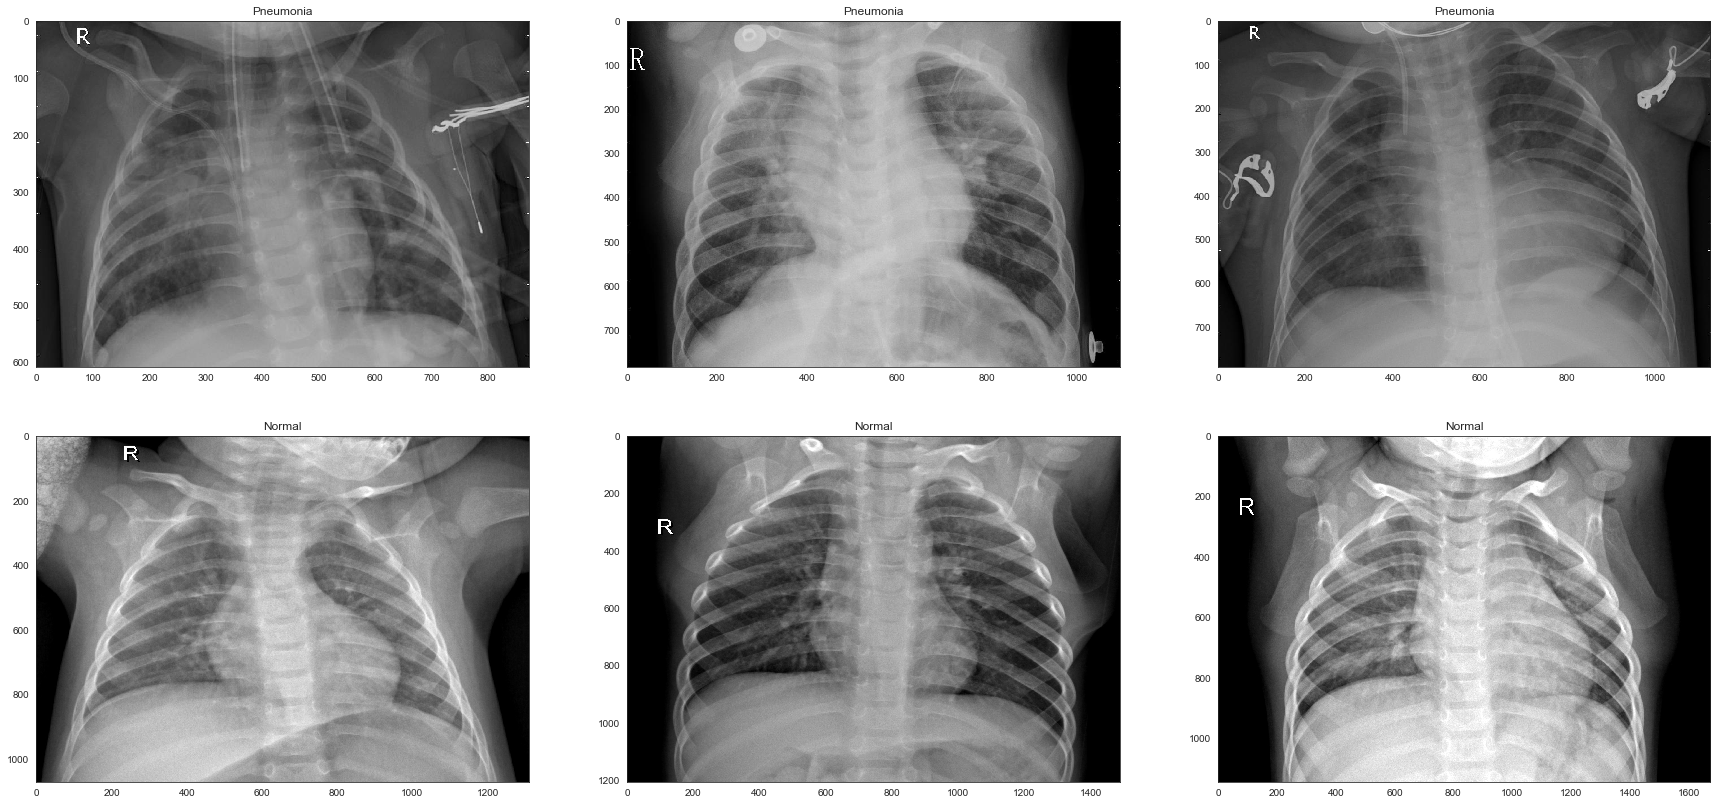

In [85]:
# Get a few samples for both of the classes
pneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:3]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:3]).tolist()

# Concat the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples

# Plot the data 
f, ax = plt.subplots(2, 3, figsize=(30, 14))

for i in range(6):
    # Read image
    img = imread(samples[i])
    # Show image
    ax[i//3, i%3].imshow(img, cmap='gray')
    ax[i//3, i%3].set_aspect('auto') # fixes alignment issues
    # Set title
    if i<3:
        ax[i//3, i%3].set_title('Pneumonia', fontsize=12)
    else:
        ax[i//3, i%3].set_title('Normal', fontsize=12)
plt.show()

I'm still unsure on to better classify the images myself. The normal images do look more clear vs. ones that are classified as pneunomia.

In [86]:
# Show an image path
print(pneumonia_samples[1])
del pneumonia_samples, normal_samples

C:\Users\David Ly\Documents\Programming\DeepLearning\07-pneunomia-radiograph-imaging\images\train\PNEUMONIA\person1926_bacteria_4835.jpeg


## Explore

Frequency of label :


,Count,Percentage
1,3875,74.29
0,1341,25.71


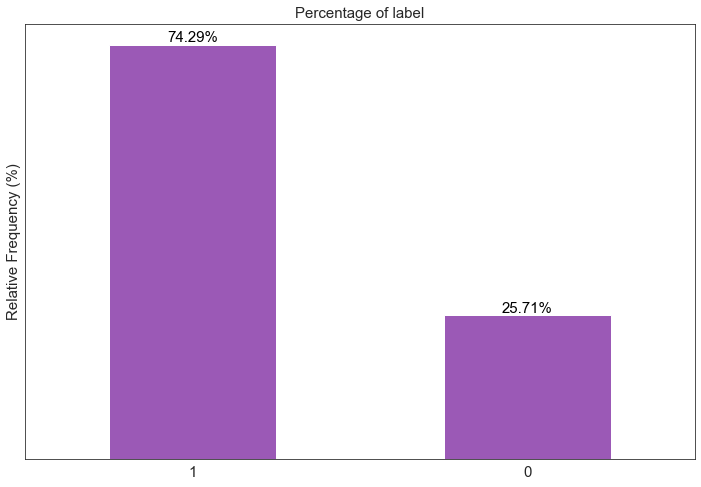

In [87]:
freq_table(train_data['label'])

The label images are unbalanced by 25% so we have to decide if we need more data to train (acquire new images, image augmentations) or downsize the dataset where it's balanced.

## Validation data

In [88]:
# Path to training images
normal_cases_dir = val_dir / 'NORMAL'
pneunomia_cases_dir = val_dir / 'PNEUMONIA'

# List of all images for training
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneunomia_cases_dir.glob('*.jpeg')

# Create empty list to store the validation data
val_data = []

# Loop through normal images and label = 0
for img in normal_cases:
    val_data.append((img, 0))
    
# Loop through pneunomia images and label = 1
for img in pneumonia_cases:
    val_data.append((img, 1))
    
# Create a dataframe
val_data = pd.DataFrame(val_data, columns=['image', 'label'], index=None)

In [89]:
val_data.groupby('label').count()

,image
label,
0,8
1,8


There's not a lot of validation data available so we have to check other methods in gathering more images or use the test set.

## Testing data

Confirm that we have the testing data.

In [90]:
test_data[0:3]

,image,label
0,C:\Users\David Ly\Documents\Programming\DeepLearning\07-pneunomia-radiograph-imaging\images\test\NORMAL\IM-0001-0001.jpeg,0
1,C:\Users\David Ly\Documents\Programming\DeepLearning\07-pneunomia-radiograph-imaging\images\test\NORMAL\IM-0003-0001.jpeg,0
2,C:\Users\David Ly\Documents\Programming\DeepLearning\07-pneunomia-radiograph-imaging\images\test\NORMAL\IM-0005-0001.jpeg,0


## Generating images

Keras allows for image augmentation. This is where we generate batches of image data with real time data augmentation. The data will be looped over in batches indefinitely. I also tested it out in one of my development notebooks [here](https://github.com/davidtnly/DeepLearning/blob/master/00-development/12-image-augment.ipynb).

[TensorFlow Keras ImageDataGenerator Doc](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

In [91]:
# Use ImageDataGenerator to feed into the network in batch sizes
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.3,
    vertical_flip=True,
    horizontal_flip=True
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.3,
    vertical_flip=True,
    horizontal_flip=True
)

# Set paths and parameters
train_gen_path = MAIN_PATH / 'train_gen'
test_gen_path = MAIN_PATH / 'test_gen'
seed=100

# Set generation object path
train_gen = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(150, 150),
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=seed,
    save_to_dir=train_gen_path
)

test_gen = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(150, 150),
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=seed,
    save_to_dir=test_gen_path
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Get test data arrays

In [95]:
test_data.groupby('label').count()

,image
label,
0,234
1,390


In [119]:
test_data_arrays = []
test_labels = []

# Loop through the test data
for num in range(test_data.image.count()):
    for img in test_data:
        # Read the image path and resize to (150, 150)
        img = plt.imread(test_data.iloc[num].image)
        img = cv2.resize(img, (150, 150))
        # Convert to 3D and scale
        img = np.dstack([img, img, img])
        img = img.astype('float32') / 255
        label = test_data.iloc[num].label
        
        # Append to list
        test_data_arrays.append(img)
        test_labels.append(label)

# Convert to arrays
test_data_arrays = np.array(test_data_arrays)
test_labels = np.array(test_labels)

In [123]:
# Confirm path, image, label, and arrays

# print('image path: ', test_data.iloc[0].image)
# print('label: ', test_data.iloc[0].label)
# print(img[0:])

## Modeling

In [130]:
# Define model parameters
EPOCHS = 10
BATCH_SIZE = 32

# Build the neural network
def build_model():
    
    # Input layer
    inputs = Input(shape=(150, 150, 3), name='input_layer')
    
    # First convolutional block
    x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', name='conv1_1')(inputs)
    x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', name='conv1_2')(x)
    x = MaxPool2D(pool_size=(2, 2), name='pool1_1')(x) # max pooling operation for spatial data
    
    # Second convolutional block
    x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='conv2_1')(x)
    x = BatchNormalization(name='bn2_1')(x) # stabilizing the learning process; reduce internal covariate shifting
    x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='conv2_2')(x)
    x = BatchNormalization(name='bn2_2')(x) 
    x = MaxPool2D(pool_size=(2, 2), name='pool2_1')(x)
    
    # Third convolutional block
    x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', name='conv3_1')(x)
    x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', name='conv3_2')(x)
    x = BatchNormalization(name='bn3_1')(x) 
    x = MaxPool2D(pool_size=(2, 2), name='pool3_1')(x)   
    
    # Fourth convolutional block
    x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same', name='conv4_1')(x)
    x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same', name='conv4_2')(x)
    x = BatchNormalization(name='bn4_1')(x) 
    x = MaxPool2D(pool_size=(2, 2), name='pool4_1')(x)
    x = Dropout(rate=0.20, name='dropout4_1')(x) # prevent network from overfitting; probabilistically reduce the network capacity
    
    # Fifth convolutional block
    x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same', name='conv5_1')(x)
    x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same', name='conv5_2')(x)
    x = BatchNormalization(name='bn5_1')(x) 
    x = MaxPool2D(pool_size=(2, 2), name='pool5_1')(x)
    x = Dropout(rate=0.30, name='dropout5_1')(x) 
    
    # Fully connected block
    x = Flatten(name='flatten6_1')(x)
    x = Dense(512, activation='relu', name='fc6_1')(x)
    x = Dropout(0.7, name='dropout6_1')(x)
    x = Dense(128, activation='relu', name='fc6_2')(x)
    x = Dropout(0.5, name='dropout6_2')(x)
    x = Dense(64, activation='relu', name='fc6_3')(x)
    x = Dropout(0.3, name='dropout6_3')(x)
    
    # Output
    output = Dense(units=1, activation='sigmoid', name='output')(x) # 1 so fewer parameters and computation are needed
    
    # Define model
    model = Model(inputs=inputs, outputs=output)
    return model

In [131]:
model =  build_model()
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 150, 150, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 150, 150, 16)      448       
_________________________________________________________________
conv1_2 (Conv2D)             (None, 150, 150, 16)      2320      
_________________________________________________________________
pool1_1 (MaxPooling2D)       (None, 75, 75, 16)        0         
_________________________________________________________________
conv2_1 (SeparableConv2D)    (None, 75, 75, 32)        688       
_________________________________________________________________
bn2_1 (BatchNormalization)   (None, 75, 75, 32)        128       
___________________________

## Compile the model

In [132]:
# Creating model and compiling
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Save weights
checkpoint = ModelCheckpoint(filepath='best_weights_16.hdf5',
                             save_best_only=True,
                             save_weights_only=True)

# Callbacks - view internal states and statistics of the model during training
lr_reduce = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=2,
                              verbose=2,
                              mode='max')

# Stop if model is not improving
early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0.1,
                           patience=1,
                           mode='min')

## Fitting the model

In [133]:
final_model = model.fit_generator(
    train_gen, 
    steps_per_epoch=train_gen.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=test_gen,
    validation_steps=test_gen.samples // BATCH_SIZE,
    callbacks=[checkpoint, lr_reduce] # early_stop
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
163/163 [==============================] - 82s 502ms/step - loss: 0.3422 - acc: 0.8388 - val_loss: 1.7437 - val_acc: 0.6480
Epoch 2/10
163/163 [==============================] - 76s 464ms/step - loss: 0.2893 - acc: 0.8823 - val_loss: 0.5643 - val_acc: 0.6723
Epoch 3/10
163/163 [==============================] - 76s 465ms/step - loss: 0.2572 - acc: 0.8915 - val_loss: 0.7408 - val_acc: 0.5659

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/10
163/163 [==============================] - 76s 467ms/step - loss: 0.2121 - acc: 0.9185 - val_loss: 0.4917 - val_acc: 0.8598
Epoch 5/10
163/163 [==============================] - 76s 465ms/step - loss: 0.1995 - acc: 0.9247 - val_loss: 1.5835 - val_acc: 0.6385

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
Epoch 6/10
163/163 [==============================] - 76s 469ms/step - loss: 0.1881 - acc: 0.9329 - val_loss: 0.318

## Load model weights

In [ ]:
# Load the model weights
model.load_weights('best_weights_16.hdf5')

## Plotting accuracy and loss

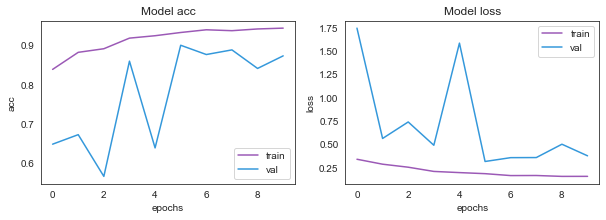

In [134]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, j in enumerate(['acc', 'loss']):
    ax[i].plot(final_model.history[j])
    ax[i].plot(final_model.history['val_' + j])
    ax[i].set_title('Model {}'.format(j))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(j)
    ax[i].legend(['train', 'val'])



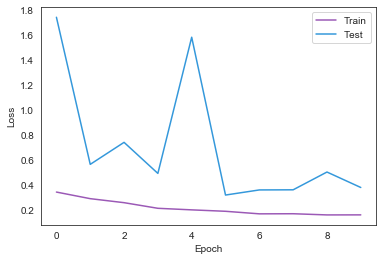

In [139]:
# Plot
def plot_loss(model):
    hist = pd.DataFrame(model.history)
    hist['epoch'] = model.epoch  
    plt.figure(figsize=(6, 4))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'],
             label='Train')
    plt.plot(hist['epoch'], hist['val_loss'],
             label = 'Test')
    plt.legend()
    plt.show()
    
plot_loss(final_model)

## Prediction

In [150]:
def PrintStats(cm, y_test, pred):
    # separate out the confusion matrix components
    tpos = cm[0][0]
    fneg = cm[1][1]
    fpos = cm[0][1]
    tneg = cm[1][0]
    # calculate F!, Recall scores
    f1Score = round(f1_score(y_test, pred), 2)
    recallScore = round(recall_score(y_test, pred), 2)
    # calculate and display metrics
    print(cmat)
    print( 'Accuracy: '+ str(np.round(100*float(tpos+fneg)/float(tpos+fneg + fpos + tneg),2))+'%')
    print("Sensitivity/Recall for Model : {recall_score}".format(recall_score = recallScore))
    print("F1 Score for Model : {f1_score}".format(f1_score = f1Score))

In [152]:
prediction = model.predict(test_data_arrays)

acc = accuracy_score(test_labels, np.round(prediction))*100
cm = confusion_matrix(test_labels, np.round(prediction))

In [155]:
test_data_arrays

array([[[[0.14117648, 0.14117648, 0.14117648],
         [0.1254902 , 0.1254902 , 0.1254902 ],
         [0.1254902 , 0.1254902 , 0.1254902 ],
         ...,
         [0.1254902 , 0.1254902 , 0.1254902 ],
         [0.13725491, 0.13725491, 0.13725491],
         [0.12941177, 0.12941177, 0.12941177]],

        [[0.11764706, 0.11764706, 0.11764706],
         [0.11764706, 0.11764706, 0.11764706],
         [0.11764706, 0.11764706, 0.11764706],
         ...,
         [0.11764706, 0.11764706, 0.11764706],
         [0.11372549, 0.11372549, 0.11372549],
         [0.12156863, 0.12156863, 0.12156863]],

        [[0.13333334, 0.13333334, 0.13333334],
         [0.1254902 , 0.1254902 , 0.1254902 ],
         [0.1254902 , 0.1254902 , 0.1254902 ],
         ...,
         [0.1254902 , 0.1254902 , 0.1254902 ],
         [0.1254902 , 0.1254902 , 0.1254902 ],
         [0.1254902 , 0.1254902 , 0.1254902 ]],

        ...,

        [[0.12156863, 0.12156863, 0.12156863],
         [0.10588235, 0.10588235, 0.10588235]

In [156]:
test_labels

array([0, 0], dtype=int64)